# A replication of the results on the Prostate Dataset from [PNet ](https://www.nature.com/articles/s41586-021-03922-4)

This notebook is an example for the use of PNet Torch and it's resemblance to the original PNet paper. 

Some of the code is taken directly from the original papers [GitHub](https://github.com/marakeby/pnet_prostate_paper)

## Import Packages and PNetTorch Modules

In [1]:
import sys
sys.path.insert(0 , './MAIN/')
from reactome import ReactomeNetwork
from Pnet import MaskedLinear , PNET
from train import *
import pandas as pd
import gc

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Load Data Using Orginal Paper Code

In [2]:
data_path = './paper_data/'
processed_path = '/'.join(['./paper_data/prostate', 'processed'])

# use this one
gene_final_no_silent_no_intron = 'P1000_final_analysis_set_cross__no_silent_no_introns_not_from_the_paper.csv'
cnv_filename = 'P1000_data_CNA_paper.csv'
response_filename = 'response_paper.csv'
gene_important_mutations_only = 'P1000_final_analysis_set_cross_important_only.csv'
gene_important_mutations_only_plus_hotspots = 'P1000_final_analysis_set_cross_important_only_plus_hotspots.csv'
gene_hotspots = 'P1000_final_analysis_set_cross_hotspots.csv'
gene_truncating_mutations_only = 'P1000_final_analysis_set_cross_truncating_only.csv'
gene_expression = 'P1000_adjusted_TPM.csv'
fusions_filename = 'p1000_onco_ets_fusions.csv'
cnv_burden_filename = 'P1000_data_CNA_burden.csv'
fusions_genes_filename = 'fusion_genes.csv'

cached_data = {}


def load_data(filename, selected_genes=None):
    filename = '/'.join([processed_path, filename])
    logging.info('loading data from %s,' % filename)
    if filename in cached_data:
        logging.info('loading from memory cached_data')
        data = cached_data[filename]
    else:
        data = pd.read_csv(filename, index_col=0)
        cached_data[filename] = data
    logging.info(data.shape)

    if 'response' in cached_data:
        logging.info('loading from memory cached_data')
        labels = cached_data['response']
    else:
        labels = get_response()
        cached_data['response'] = labels

    # remove all zeros columns (note the column may be added again later if another feature type belongs to the same gene has non-zero entries).
    # zero_cols = data.sum(axis=0) == 0
    # data = data.loc[:, ~zero_cols]

    # join with the labels
    all = data.join(labels, how='inner')
    all = all[~all['response'].isnull()]

    response = all['response']
    samples = all.index

    del all['response']
    x = all
    genes = all.columns

    if not selected_genes is None:
        intersect = set.intersection(set(genes), selected_genes)
        if len(intersect) < len(selected_genes):
            # raise Exception('wrong gene')
            logging.warning('some genes dont exist in the original data set')
        x = x.loc[:, list(intersect)]
        genes = intersect
    logging.info('loaded data %d samples, %d variables, %d responses ' % (x.shape[0], x.shape[1], response.shape[0]))
    logging.info(len(genes))
    return x, response, samples, genes


def load_TMB(filename=gene_final_no_silent_no_intron):
    x, response, samples, genes = load_data(filename)
    x = np.sum(x, axis=1)
    x = np.array(x)
    x = np.log(1. + x)
    n = x.shape[0]
    response = response.values.reshape((n, 1))
    samples = np.array(samples)
    cols = np.array(['TMB'])
    return x, response, samples, cols


def load_CNV_burden(filename=gene_final_no_silent_no_intron):
    x, response, samples, genes = load_data(filename)
    x = np.sum(x, axis=1)
    x = np.array(x)
    x = np.log(1. + x)
    n = x.shape[0]
    response = response.values.reshape((n, 1))
    samples = np.array(samples)
    cols = np.array(['TMB'])
    return x, response, samples, cols


def load_data_type(data_type='gene', cnv_levels=5, cnv_filter_single_event=True, mut_binary=False, selected_genes=None):
    logging.info('loading {}'.format(data_type))
    if data_type == 'TMB':
        x, response, info, genes = load_TMB(gene_important_mutations_only)
    if data_type == 'mut_no_silent_no_intron':
        x, response, info, genes = load_data(gene_final_no_silent_no_intron, selected_genes)
        if mut_binary:
            logging.info('mut_binary = True')
            x[x > 1.] = 1.

    if data_type == 'mut_important':
        x, response, info, genes = load_data(gene_important_mutations_only, selected_genes)
        if mut_binary:
            logging.info('mut_binary = True')
            x[x > 1.] = 1.

    if data_type == 'mut_important_plus_hotspots':
        x, response, info, genes = load_data(gene_important_mutations_only_plus_hotspots, selected_genes)

    if data_type == 'mut_hotspots':
        x, response, info, genes = load_data(gene_hotspots, selected_genes)

    if data_type == 'truncating_mut':
        x, response, info, genes = load_data(gene_truncating_mutations_only, selected_genes)
        if mut_binary:
            logging.info('mut_binary = True')
            x[x > 1.] = 1.

    if data_type == 'gene_final_no_silent':
        x, response, info, genes = load_data(gene_final_no_silent, selected_genes)
    if data_type == 'cnv':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        if cnv_levels == 3:
            logging.info('cnv_levels = 3')
            # remove single amplification and single delteion, they are usually noisey
            if cnv_levels == 3:
                if cnv_filter_single_event:
                    x[x == -1.] = 0.0
                    x[x == -2.] = 1.0
                    x[x == 1.] = 0.0
                    x[x == 2.] = 1.0
                else:
                    x[x < 0.] = -1.
                    x[x > 0.] = 1.

    if data_type == 'cnv_del':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x >= 0.0] = 0.
        if cnv_levels == 3:
            if cnv_filter_single_event:
                x[x == -1.] = 0.0
                x[x == -2.] = 1.0
            else:
                x[x < 0.0] = 1.0
        else:  # cnv == 5 , use everything
            x[x == -1.] = 0.5
            x[x == -2.] = 1.0

    if data_type == 'cnv_amp':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x <= 0.0] = 0.
        if cnv_levels == 3:
            if cnv_filter_single_event:
                x[x == 1.0] = 0.0
                x[x == 2.0] = 1.0
            else:
                x[x > 0.0] = 1.0
        else:  # cnv == 5 , use everything
            x[x == 1.] = 0.5
            x[x == 2.] = 1.0

    if data_type == 'cnv_single_del':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x == -1.] = 1.0
        x[x != -1.] = 0.0
    if data_type == 'cnv_single_amp':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x == 1.] = 1.0
        x[x != 1.] = 0.0
    if data_type == 'cnv_high_amp':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x == 2.] = 1.0
        x[x != 2.] = 0.0
    if data_type == 'cnv_deep_del':
        x, response, info, genes = load_data(cnv_filename, selected_genes)
        x[x == -2.] = 1.0
        x[x != -2.] = 0.0

    if data_type == 'gene_expression':
        x, response, info, genes = load_data(gene_expression, selected_genes)

    if data_type == 'fusions':
        x, response, info, genes = load_data(fusions_filename, None)

    if data_type == 'cnv_burden':
        x, response, info, genes = load_data(cnv_burden_filename, None)
        # x.loc[:, :] = 0.

    if data_type == 'fusion_genes':
        x, response, info, genes = load_data(fusions_genes_filename, selected_genes)
        # x.loc[:,:]=0.

    return x, response, info, genes


def get_response():
    logging.info('loading response from %s' % response_filename)
    labels = pd.read_csv('/'.join([processed_path, response_filename]))
    labels = labels.set_index('id')
    return labels


# complete_features: make sure all the data_types have the same set of features_processing (genes)
def combine(x_list, y_list, rows_list, cols_list, data_type_list, combine_type, use_coding_genes_only=False):
    cols_list_set = [set(list(c)) for c in cols_list]

    if combine_type == 'intersection':
        cols = set.intersection(*cols_list_set)
    else:
        cols = set.union(*cols_list_set)

    if use_coding_genes_only:
        f = '/'.join([data_path, 'genes/HUGO_genes/protein-coding_gene_with_coordinate_minimal.txt'])
        coding_genes_df = pd.read_csv(f, sep='\t', header=None)
        coding_genes_df.columns = ['chr', 'start', 'end', 'name']
        coding_genes = set(coding_genes_df['name'].unique())
        cols = cols.intersection(coding_genes)

    # the unique (super) set of genes
    all_cols = list(cols)

    all_cols_df = pd.DataFrame(index=all_cols)

    df_list = []
    for x, y, r, c in zip(x_list, y_list, rows_list, cols_list):
        df = pd.DataFrame(x, columns=list(c), index=list(r))
        df = df.T.join(all_cols_df, how='right')
        df = df.T
        df = df.fillna(0)
        df_list.append(df)

    all_data = pd.concat(df_list, keys=data_type_list, join='inner', axis=1, )

    # put genes on the first level and then the data type
    all_data = all_data.swaplevel(i=0, j=1, axis=1)

    # order the columns based on genes
    order = all_data.columns.levels[0]
    all_data = all_data.reindex(columns=order, level=0)

    x = all_data.values

    reordering_df = pd.DataFrame(index=all_data.index)
    y = reordering_df.join(y, how='left')

    y = y.values
    cols = all_data.columns
    rows = all_data.index
    logging.info(
        'After combining, loaded data %d samples, %d variables, %d responses ' % (x.shape[0], x.shape[1], y.shape[0]))

    return x, y, rows, cols


def split_cnv(x_df):
    genes = x_df.columns.levels[0]
    x_df.rename(columns={'cnv': 'CNA_amplification'}, inplace=True)
    for g in genes:
        x_df[g, 'CNA_deletion'] = x_df[g, 'CNA_amplification'].replace({-1.0: 0.5, -2.0: 1.0})
        x_df[g, 'CNA_amplification'] = x_df[g, 'CNA_amplification'].replace({1.0: 0.5, 2.0: 1.0})
    x_df = x_df.reindex(columns=genes, level=0)
    return x_df


class ProstateDataPaper():

    def __init__(self, data_type='mut', account_for_data_type=None, cnv_levels=5,
                 cnv_filter_single_event=True, mut_binary=False,
                 selected_genes=None, combine_type='intersection',
                 use_coding_genes_only=False, drop_AR=False,
                 balanced_data=False, cnv_split=False,
                 shuffle=False, selected_samples=None, training_split=0):

        self.training_split = training_split
        if not selected_genes is None:
            if type(selected_genes) == list:
                # list of genes
                selected_genes = selected_genes
            else:
                # file that will be used to load list of genes
                selected_genes_file = '/'.join([data_path, 'genes'])
                selected_genes_file = '/'.join([selected_genes_file, selected_genes])
                df = pd.read_csv(selected_genes_file, header=0)
                selected_genes = list(df['genes'])

        if type(data_type) == list:
            x_list = []
            y_list = []
            rows_list = []
            cols_list = []

            for t in data_type:
                x, y, rows, cols = load_data_type(t, cnv_levels, cnv_filter_single_event, mut_binary, selected_genes)
                x_list.append(x), y_list.append(y), rows_list.append(rows), cols_list.append(cols)
            x, y, rows, cols = combine(x_list, y_list, rows_list, cols_list, data_type, combine_type,
                                       use_coding_genes_only)
            x = pd.DataFrame(x, columns=cols)

        else:
            x, y, rows, cols = load_data_type(data_type, cnv_levels, cnv_filter_single_event, mut_binary,
                                              selected_genes)

        if drop_AR:

            data_types = x.columns.levels[1].unique()
            ind = True
            if 'cnv' in data_types:
                ind = x[('AR', 'cnv')] <= 0.
            elif 'cnv_amp' in data_types:
                ind = x[('AR', 'cnv_amp')] <= 0.

            if 'mut_important' in data_types:
                ind2 = (x[('AR', 'mut_important')] < 1.)
                ind = ind & ind2
            x = x.loc[ind,]
            y = y[ind]
            rows = rows[ind]

        if cnv_split:
            x = split_cnv(x)

        if type(x) == pd.DataFrame:
            x = x.values

        if balanced_data:
            pos_ind = np.where(y == 1.)[0]
            neg_ind = np.where(y == 0.)[0]

            n_pos = pos_ind.shape[0]
            n_neg = neg_ind.shape[0]
            n = min(n_pos, n_neg)

            pos_ind = np.random.choice(pos_ind, size=n, replace=False)
            neg_ind = np.random.choice(neg_ind, size=n, replace=False)

            ind = np.sort(np.concatenate([pos_ind, neg_ind]))

            y = y[ind]
            x = x[ind,]
            rows = rows[ind]

        if shuffle:
            n = x.shape[0]
            ind = np.arange(n)
            np.random.shuffle(ind)
            x = x[ind, :]
            y = y[ind, :]
            rows = rows[ind]

        if account_for_data_type is not None:
            x_genomics = pd.DataFrame(x, columns=cols, index=rows)
            y_genomics = pd.DataFrame(y, index=rows, columns=['response'])
            x_list = []
            y_list = []
            rows_list = []
            cols_list = []
            for t in account_for_data_type:
                x_, y_, rows_, cols_ = load_data_type(t, cnv_levels, cnv_filter_single_event, mut_binary,
                                                      selected_genes)
                x_df = pd.DataFrame(x_, columns=cols_, index=rows_)
                x_list.append(x_df), y_list.append(y_), rows_list.append(rows_), cols_list.append(cols_)

            x_account_for = pd.concat(x_list, keys=account_for_data_type, join='inner', axis=1)
            x_all = pd.concat([x_genomics, x_account_for], keys=['genomics', 'account_for'], join='inner', axis=1)

            common_samples = set(rows).intersection(x_all.index)
            x_all = x_all.loc[common_samples, :]
            y = y_genomics.loc[common_samples, :]

            y = y['response'].values
            x = x_all.values
            cols = x_all.columns
            rows = x_all.index

        if selected_samples is not None:
            selected_samples_file = join(processed_path, selected_samples)
            df = pd.read_csv(selected_samples_file, header=0)
            selected_samples_list = list(df['Tumor_Sample_Barcode'])

            x = pd.DataFrame(x, columns=cols, index=rows)
            y = pd.DataFrame(y, index=rows, columns=['response'])

            x = x.loc[selected_samples_list, :]
            y = y.loc[selected_samples_list, :]
            rows = x.index
            cols = x.columns
            y = y['response'].values
            x = x.values

        self.x = x
        self.y = y
        self.info = rows
        self.columns = cols

    def get_data(self):
        return self.x, self.y, self.info, self.columns

    def get_train_validate_test(self):
        info = self.info
        x = self.x
        y = self.y
        columns = self.columns
        splits_path = join(PROSTATE_DATA_PATH, 'splits')

        training_file = 'training_set_{}.csv'.format(self.training_split)
        training_set = pd.read_csv(join(splits_path, training_file))

        validation_set = pd.read_csv(join(splits_path, 'validation_set.csv'))
        testing_set = pd.read_csv(join(splits_path, 'test_set.csv'))

        info_train = list(set(info).intersection(training_set.id))
        info_validate = list(set(info).intersection(validation_set.id))
        info_test = list(set(info).intersection(testing_set.id))

        ind_train = info.isin(info_train)
        ind_validate = info.isin(info_validate)
        ind_test = info.isin(info_test)

        x_train = x[ind_train]
        x_test = x[ind_test]
        x_validate = x[ind_validate]

        y_train = y[ind_train]
        y_test = y[ind_test]
        y_validate = y[ind_validate]

        info_train = info[ind_train]
        info_test = info[ind_test]
        info_validate = info[ind_validate]

        return x_train, x_validate, x_test, y_train, y_validate, y_test, info_train.copy(), info_validate, info_test.copy(), columns


In [3]:
import logging
import numpy as np

task = 'classification_binary'
selected_genes = 'tcga_prostate_expressed_genes_and_cancer_genes.csv'
data_base = {'id': 'ALL', 'type': 'prostate_paper',
             'params': {
                 'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
                 'drop_AR': False,
                 'cnv_levels': 3,
                 'mut_binary': True,
                 'balanced_data': False,
                 'combine_type': 'union',  # intersection
                 'use_coding_genes_only': True,
                 'selected_genes': selected_genes,
                 'training_split': 0,
             }
             }

class Data():
    def __init__(self, id, type, params, test_size=0.3, stratify=True):

        self.test_size = test_size
        self.stratify = stratify
        self.data_type = type
        self.data_params = params
        if self.data_type == 'prostate_paper':
            self.data_reader = ProstateDataPaper(**params)
        else:
            logging.error('unsupported data type')
            raise ValueError('unsupported data type')

    def get_train_validate_test(self):
        return self.data_reader.get_train_validate_test()

    def get_train_test(self):
        x_train, x_validate, x_test, y_train, y_validate, y_test, info_train, info_validate, info_test, columns = self.data_reader.get_train_validate_test()
        # combine training and validation datasets
        x_train = np.concatenate((x_train, x_validate))
        y_train = np.concatenate((y_train, y_validate))
        info_train = list(info_train) + list(info_validate)
        return x_train, x_test, y_train, y_test, info_train, info_test, columns

    def get_data(self):
        x = self.data_reader.x
        y = self.data_reader.y
        info = self.data_reader.info
        columns = self.data_reader.columns
        return x, y, info, columns

    def get_relevant_features(self):
        if hasattr(self.data_reader, 'relevant_features'):
            return self.data_reader.get_relevant_features()
        else:
            return None

data = Data(**data_base)

### Check Data

In [4]:
x, y, info, columns = data.get_data()

In [5]:
# Input data to learn
x.shape

(1011, 27687)

In [6]:
# Targets
y.shape

(1011, 1)

In [7]:
# Patient ID's
info[:5]

Index(['00-029N9_LN', '01-087MM_BONE', '01-095N1_LN', '01-120A1_LIVER',
       '02-083E1_LN'],
      dtype='object')

In [8]:
# Features - NOTE : Multi-index column with mappings directly from datasets to gene
columns[:5]

MultiIndex([('SP4', 'mut_important'),
            ('SP4',       'cnv_del'),
            ('SP4',       'cnv_amp'),
            ('SST', 'mut_important'),
            ('SST',       'cnv_del')],
           )

## Run PNetTorch on Paper

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x, y, info, columns = data.get_data()

# The original paper mask process the input to have direct mappings to genes. For replication in this example
# we will also mask the input. 
input_mask = pd.DataFrame(0, index=columns.get_level_values(0).unique(), columns=columns)  # Initialize all zeros

# Mask the inputs for dataset to gene (3:1) mapping
for row in input_mask.index:
    input_mask.loc[row , row] = 1
    
input_mask_arr = input_mask.T.values
del input_mask

# Highly recommend running on GPU or in HPC environment
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Build network to obtain gene and pathway relationships
net = ReactomeNetwork(genes_of_interest=np.unique(list(columns.get_level_values(0))) , n_levels=5)

# Build PNet model
model = PNET(reactome_network=net, input_dim=x.shape[1] , output_dim=np.unique(y).shape[0], 
                  activation = nn.ReLU() , dropout=0.5 , filter_pathways=False , input_layer_mask = input_mask_arr)

print(model)

# Convert classifications to One Hot Encodings
y = F.one_hot(torch.Tensor(y).to(torch.int64)).squeeze().numpy()

# Train Model
model , train_loader , test_loader = train(model , x , y , device , batch_size = 256 , 
                                                 num_epochs=50 , learning_rate=0.05 , sparse=False)
# Evaluate
metrics = evaluate(model, test_loader)
print(metrics)

PNET(
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layers): ModuleList(
    (0): MaskedLinear(in_features=27687, out_features=9229, bias=True)
    (1): MaskedLinear(in_features=9229, out_features=1397, bias=True)
    (2): MaskedLinear(in_features=1397, out_features=1066, bias=True)
    (3): MaskedLinear(in_features=1066, out_features=447, bias=True)
    (4): MaskedLinear(in_features=447, out_features=147, bias=True)
    (5): MaskedLinear(in_features=147, out_features=26, bias=True)
  )
  (skip): ModuleList(
    (0): Linear(in_features=9229, out_features=2, bias=True)
    (1): Linear(in_features=1397, out_features=2, bias=True)
    (2): Linear(in_features=1066, out_features=2, bias=True)
    (3): Linear(in_features=447, out_features=2, bias=True)
    (4): Linear(in_features=147, out_features=2, bias=True)
    (5): Linear(in_features=26, out_features=2, bias=True)
  )
)


Epoch 50: 100%|██████████| 50/50 [07:00<00:00,  8.40s/epoch, loss=0.674]

Training complete.
              precision    recall  f1-score   support

           0     0.8609    0.9559    0.9059       136
           1     0.8846    0.6866    0.7731        67

    accuracy                         0.8670       203
   macro avg     0.8728    0.8212    0.8395       203
weighted avg     0.8687    0.8670    0.8621       203



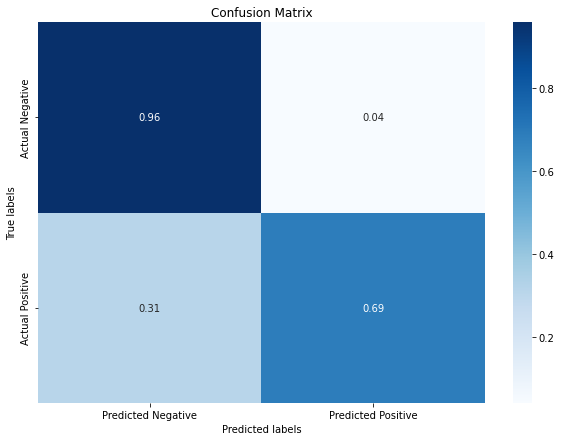

AUC Score: 0.9190079016681298


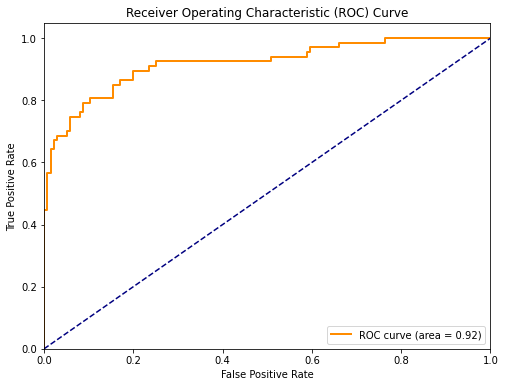

In [10]:
actuals, predictions = get_predictions(model, test_loader)

cm = plot_confusion_matrix(actuals , predictions)

actuals, probs = get_probabilities(model, test_loader)
# Assuming `probs` has been calculated as the probability outcomes for class 1, if not implement it
auc = roc_auc_score(actuals, probs)
fpr, tpr, _ = roc_curve(actuals, probs)
print("AUC Score:", auc)

roc = plot_roc_curve(fpr , tpr , auc)

In [11]:
non_zero_sum = 0
for param in model.parameters():
    non_zero_elements = (param != 0) # filter non-zero elements
    non_zero_sum += non_zero_elements.sum()  # sum them up

print("Sum of non-zero parameters:", non_zero_sum.item())

Sum of non-zero parameters: 130720


### Functions for checking and clearing GPU memory if required

In [ ]:
get_gpu_memory()
#del model , train_loader , test_loader
torch.cuda.reset_accumulated_memory_stats()
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory()

## Interpretability

In [12]:
from interpret import interpret , evaluate_interpret_save

Save Path Not Found - Plots will not be saved


C:\Users\Barry\anaconda3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\Barry\anaconda3\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


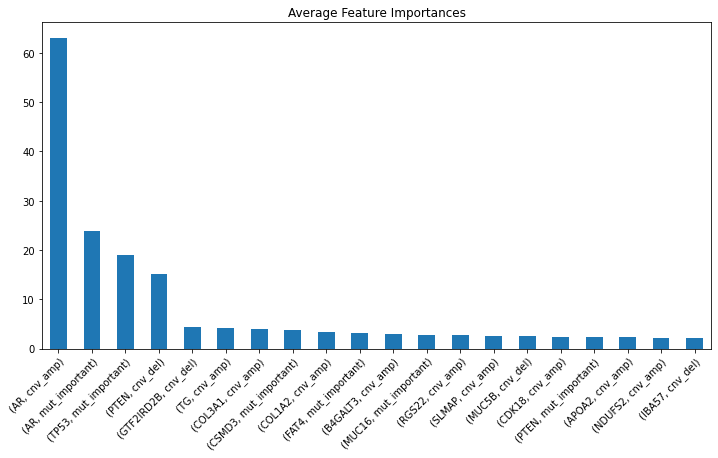

MaskedLinear(in_features=27687, out_features=9229, bias=True)
MaskedLinear(in_features=9229, out_features=1397, bias=True)
MaskedLinear(in_features=1397, out_features=1066, bias=True)
MaskedLinear(in_features=1066, out_features=447, bias=True)
MaskedLinear(in_features=447, out_features=147, bias=True)
MaskedLinear(in_features=147, out_features=26, bias=True)


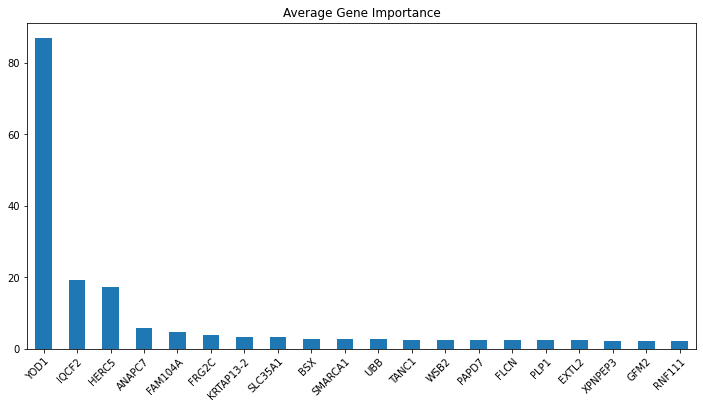

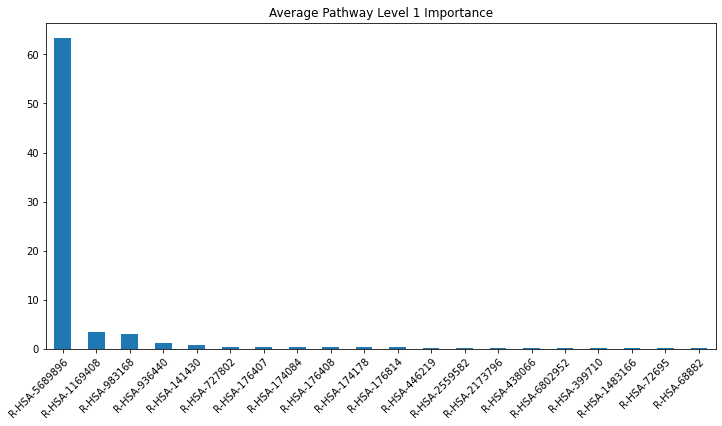

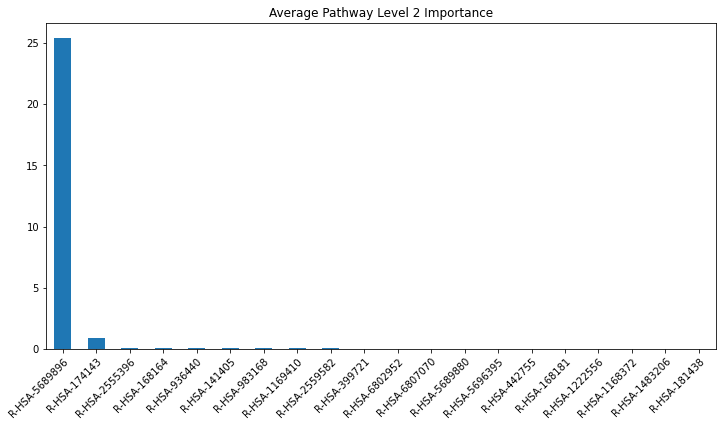

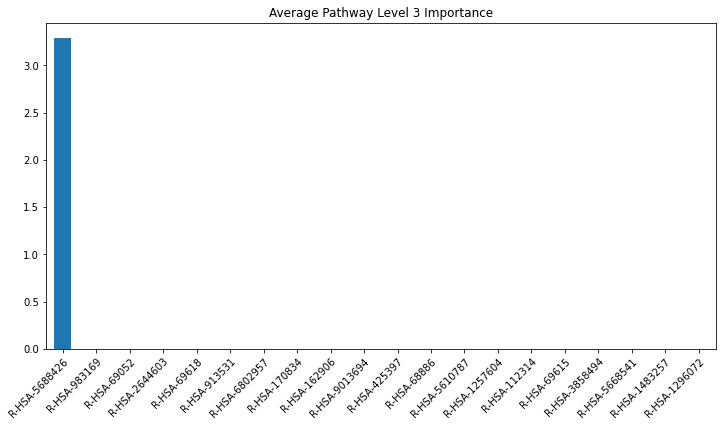

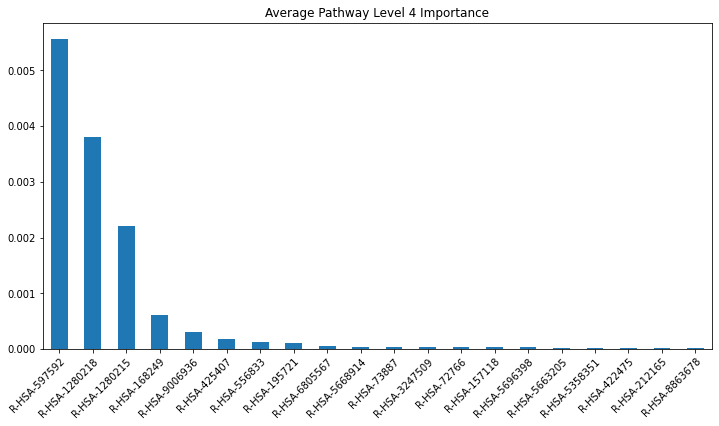

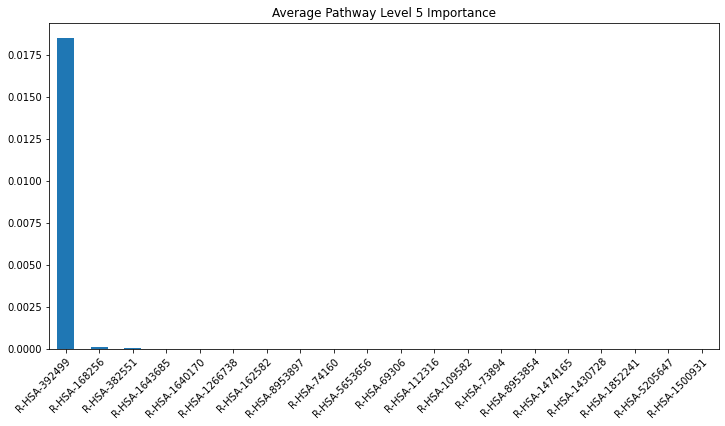

In [13]:
# Extract all data and targets using list comprehensions
data_batches, target_batches = zip(*[(data, target) for data, target in test_loader])

# Convert lists of batches into single tensors
test_data = torch.cat(data_batches, dim=0)
test_targets = torch.cat(target_batches , dim =0)

# Assign the model features to the columns
model.features = columns

model_importances = interpret(model , test_data , savedir='None')

## Generate and Save Metrics + Importance

Single function to generate and save all model metrics and importances

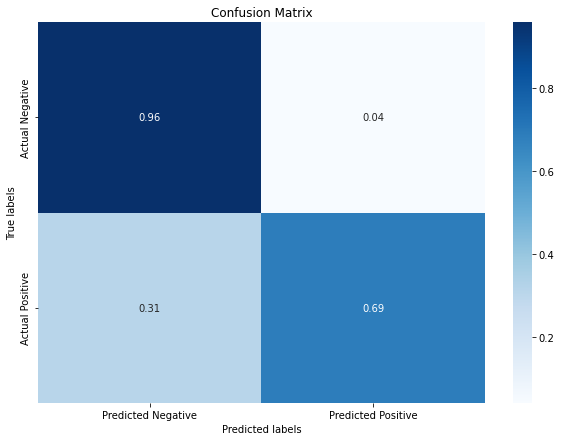

AUC Score: 0.9190079016681298


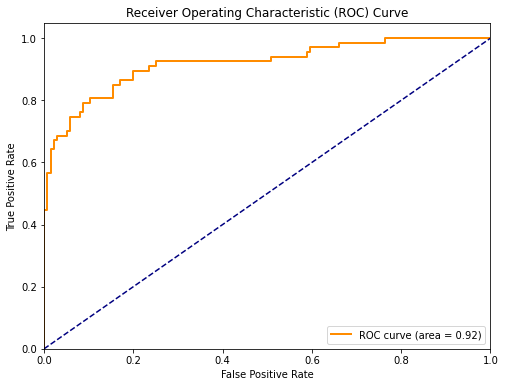

C:\Users\Barry\anaconda3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
C:\Users\Barry\anaconda3\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


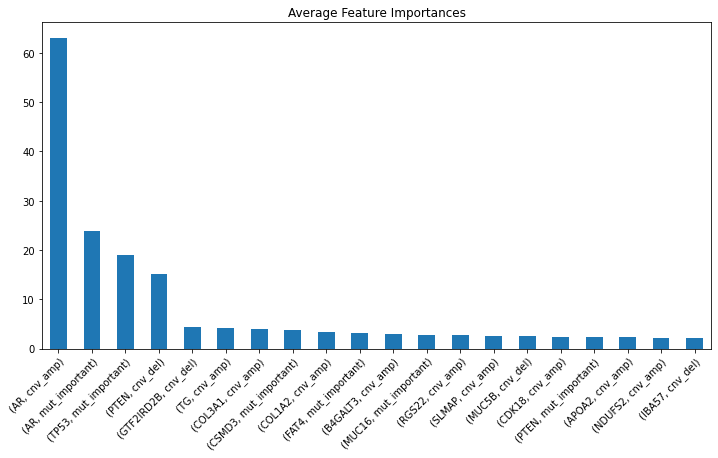

MaskedLinear(in_features=27687, out_features=9229, bias=True)
MaskedLinear(in_features=9229, out_features=1397, bias=True)
MaskedLinear(in_features=1397, out_features=1066, bias=True)
MaskedLinear(in_features=1066, out_features=447, bias=True)
MaskedLinear(in_features=447, out_features=147, bias=True)
MaskedLinear(in_features=147, out_features=26, bias=True)


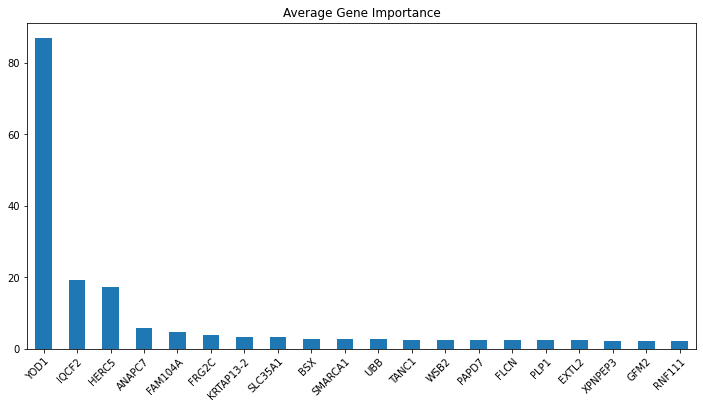

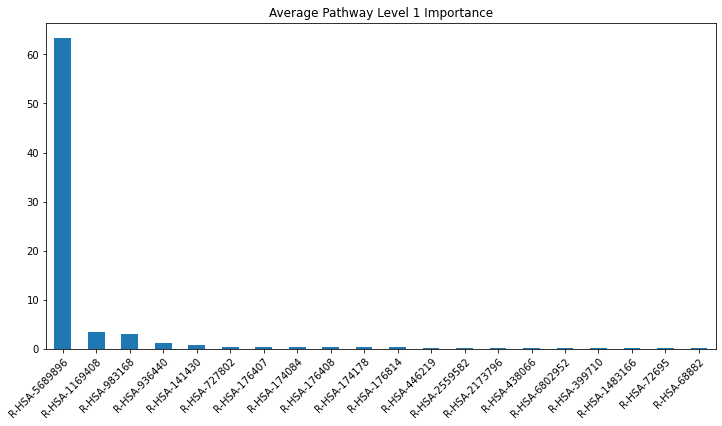

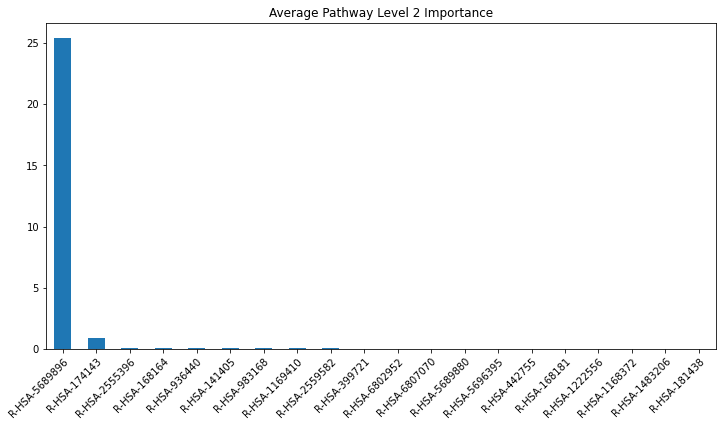

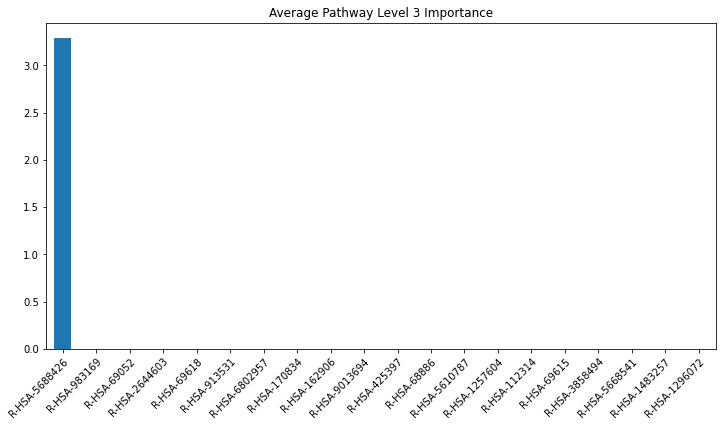

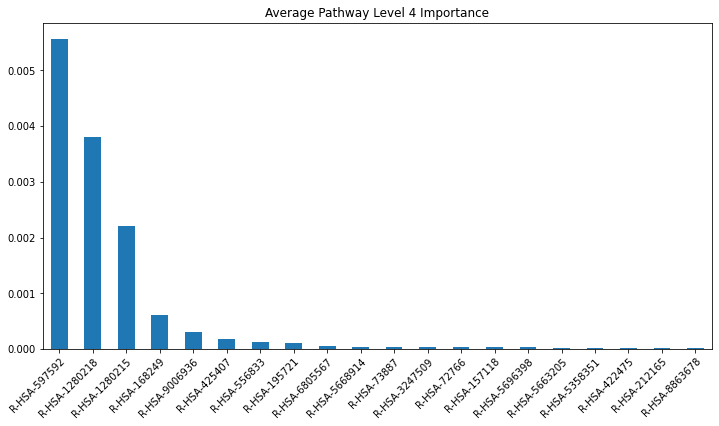

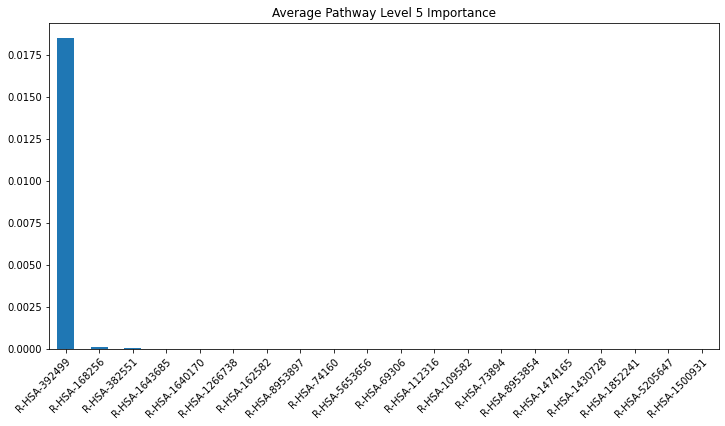

In [14]:
evaluate_interpret_save(model , test_loader , './Output/Prostate')